In [ ]:
raw_data_path = '/content/drive/My Drive/transformer/data/news.csv'
destination_folder = '/content/drive/My Drive/transformer/data'

In [ ]:
train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [ ]:
df_raw = pd.read_csv(raw_data_path)

df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [ ]:
source_folder = '/content/drive/My Drive/transformer/data'
destination_folder = '/content/drive/My Drive/transformer/model'

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 4.2MB/s 
     |████████████████████████████████| 890kB 25.9MB/s 
     |████████████████████████████████| 3.2MB 21.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0e12bc5841b95c275f610726f2a303738eee19a17a2b2fb3e214a701432c70e7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)


train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [ ]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            running_loss += loss.item()
            global_step += 1

            
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.7374, Valid Loss: 0.6584
Model saved to ==> /content/drive/My Drive/transformer/model/model.pt
Model saved to ==> /content/drive/My Drive/transformer/model/metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.5462, Valid Loss: 0.4471
Model saved to ==> /content/drive/My Drive/transformer/model/model.pt
Model saved to ==> /content/drive/My Drive/transformer/model/metrics.pt
Epoch [2/5], Step [48/160], Train Loss: 0.4289, Valid Loss: 0.3095
Model saved to ==> /content/drive/My Drive/transformer/model/model.pt
Model saved to ==> /content/drive/My Drive/transformer/model/metrics.pt
Epoch [2/5], Step [64/160], Train Loss: 0.2248, Valid Loss: 0.3089
Model saved to ==> /content/drive/My Drive/transformer/model/model.pt
Model saved to ==> /content/drive/My Drive/transformer/model/metrics.pt
Epoch [3/5], Step [80/160], Train Loss: 0.1886, Valid Loss: 0.2897
Model saved to ==> /content/drive/My Drive/transformer/model/model.pt
Model saved to ==> /content

Model loaded from <== /content/drive/My Drive/transformer/model/metrics.pt


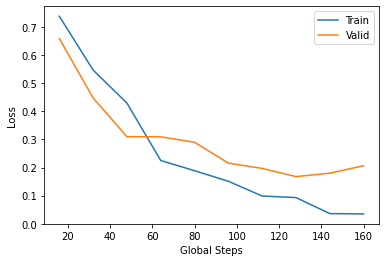

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 